In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/Users/Snigdha1/Downloads/sentiment-predictor-for-stress-detection-main/Audio_Speech_Actors_01-24/Actor_25/03-01-08-02-01-02-25.wav')

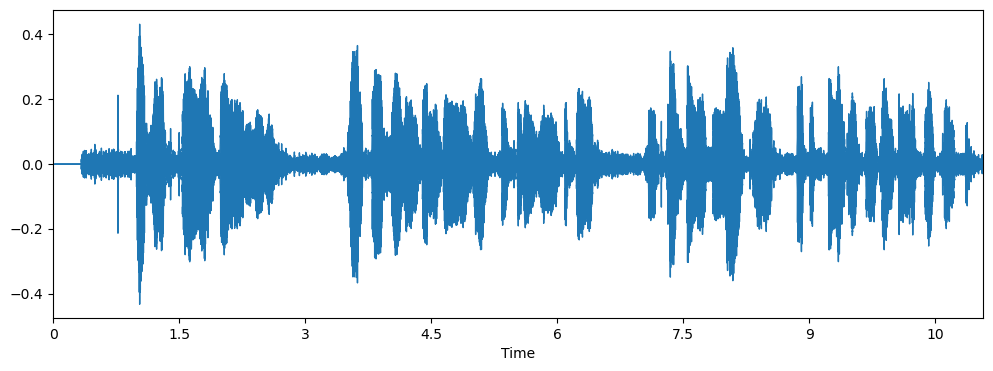

In [5]:
%matplotlib inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [6]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('/Users/Snigdha1/Downloads/sentiment-predictor-for-stress-detection-main/Audio_Speech_Actors_01-24/Actor_25/03-01-08-02-01-02-25.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

ValueError: operands could not be broadcast together with shapes (1440,) (1440,2) 

In [7]:
import time

path = '/Users/arushtripathi/Downloads/sentiment-predictor-for-stress-detection-main/Audio_Speech_Actors_01-24/Actor_25/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 1.1845083236694336 seconds ---


In [8]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [9]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((9, 40), (9,))

In [10]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/Snigdha1/Downloads/sentiment-predictor-for-stress-detection-main/Saved_Models/'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))


In [11]:
# Loading saved models

X = joblib.load('/Users/Snigdha1/Downloads/Sentiment-predictor-for-stress-detection-main/Saved_Models/X.joblib')
y = joblib.load('/Users/Snigdha1/Downloads/sentiment-predictor-for-stress-detection-main/Saved_Models/y.joblib')

## Decision Tree Model

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
dtree = DecisionTreeClassifier()

In [15]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [16]:
predictions = dtree.predict(X_test)

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       1.0
           7       0.00      0.00      0.00       1.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



/Users/arushtripathi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arushtripathi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arushtripathi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arush

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier


In [19]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [20]:
rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=22000, random_state=5)

In [21]:
predictions = rforest.predict(X_test)

In [22]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           7       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3



/Users/arushtripathi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arushtripathi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arushtripathi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
##Neural Network
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [24]:
x_traincnn.shape, x_testcnn.shape

((6, 40, 1), (3, 40, 1))

In [31]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import backend as k
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.legacy.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

/Users/arushtripathi/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 40, 128)           768       
                                                                 
 activation_18 (Activation)  (None, 40, 128)           0         
                                                                 
 dropout_12 (Dropout)        (None, 40, 128)           0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 5, 128)            82048     
                                                                 
 activation_19 (Activation)  (None, 5, 128)            0         
                                                      

In [33]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Epoch 1/1000
1/1 [==============================] - 0s 318ms/step - loss: 9.2371 - accuracy: 0.3333 - val_loss: 10.3168 - val_accuracy: 0.3333
Epoch 2/1000
1/1 [==============================] - 0s 16ms/step - loss: 12.3204 - accuracy: 0.3333 - val_loss: 14.4653 - val_accuracy: 0.0000e+00
Epoch 3/1000
1/1 [==============================] - 0s 16ms/step - loss: 13.0680 - accuracy: 0.1667 - val_loss: 10.1157 - val_accuracy: 0.0000e+00
Epoch 4/1000
1/1 [==============================] - 0s 13ms/step - loss: 7.5048 - accuracy: 0.1667 - val_loss: 13.2210 - val_accuracy: 0.0000e+00
Epoch 5/1000
1/1 [==============================] - 0s 11ms/step - loss: 7.4115 - accuracy: 0.1667 - val_loss: 8.3803 - val_accuracy: 0.0000e+00
Epoch 6/1000
1/1 [==============================] - 0s 13ms/step - loss: 4.3916 - accuracy: 0.3333 - val_loss: 8.6291 - val_accuracy: 0.0000e+00
Epoch 7/1000
1/1 [==============================] - 0s 13ms/step - loss: 3.3920 - accuracy: 0.3333 - val_loss: 11.3995 - val_ac

Epoch 113/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.1592 - accuracy: 1.0000 - val_loss: 14.2545 - val_accuracy: 0.0000e+00
Epoch 114/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5284 - accuracy: 0.8333 - val_loss: 14.2850 - val_accuracy: 0.0000e+00
Epoch 115/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 15.1346 - val_accuracy: 0.0000e+00
Epoch 116/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 16.0172 - val_accuracy: 0.0000e+00
Epoch 117/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0645 - accuracy: 1.0000 - val_loss: 16.7123 - val_accuracy: 0.0000e+00
Epoch 118/1000
1/1 [==============================] - 0s 12ms/step - loss: 1.7744 - accuracy: 0.8333 - val_loss: 16.5554 - val_accuracy: 0.0000e+00
Epoch 119/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.8986 - accuracy: 0.8333 - val_loss:

Epoch 223/1000
1/1 [==============================] - 0s 11ms/step - loss: 5.6181e-04 - accuracy: 1.0000 - val_loss: 16.7396 - val_accuracy: 0.0000e+00
Epoch 224/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.7765e-04 - accuracy: 1.0000 - val_loss: 16.7421 - val_accuracy: 0.0000e+00
Epoch 225/1000
1/1 [==============================] - 0s 12ms/step - loss: 8.5247e-04 - accuracy: 1.0000 - val_loss: 16.7453 - val_accuracy: 0.0000e+00
Epoch 226/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 16.7515 - val_accuracy: 0.0000e+00
Epoch 227/1000
1/1 [==============================] - 0s 11ms/step - loss: 3.6798e-04 - accuracy: 1.0000 - val_loss: 16.7579 - val_accuracy: 0.0000e+00
Epoch 228/1000
1/1 [==============================] - 0s 12ms/step - loss: 7.5091e-04 - accuracy: 1.0000 - val_loss: 16.7644 - val_accuracy: 0.0000e+00
Epoch 229/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.5645e-04 - accu

1/1 [==============================] - 0s 12ms/step - loss: 2.8330e-04 - accuracy: 1.0000 - val_loss: 15.9221 - val_accuracy: 0.0000e+00
Epoch 332/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.8005e-04 - accuracy: 1.0000 - val_loss: 15.9326 - val_accuracy: 0.0000e+00
Epoch 333/1000
1/1 [==============================] - 0s 12ms/step - loss: 6.6972e-05 - accuracy: 1.0000 - val_loss: 15.9421 - val_accuracy: 0.0000e+00
Epoch 334/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 15.9534 - val_accuracy: 0.0000e+00
Epoch 335/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.2046e-04 - accuracy: 1.0000 - val_loss: 15.9634 - val_accuracy: 0.0000e+00
Epoch 336/1000
1/1 [==============================] - 0s 12ms/step - loss: 7.3108e-05 - accuracy: 1.0000 - val_loss: 15.9726 - val_accuracy: 0.0000e+00
Epoch 337/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0016 - accuracy: 1.0000 - val_

1/1 [==============================] - 0s 12ms/step - loss: 4.1463e-05 - accuracy: 1.0000 - val_loss: 16.7643 - val_accuracy: 0.0000e+00
Epoch 440/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2026e-04 - accuracy: 1.0000 - val_loss: 16.7598 - val_accuracy: 0.0000e+00
Epoch 441/1000
1/1 [==============================] - 0s 14ms/step - loss: 2.8311e-05 - accuracy: 1.0000 - val_loss: 16.7557 - val_accuracy: 0.0000e+00
Epoch 442/1000
1/1 [==============================] - 0s 12ms/step - loss: 4.3529e-05 - accuracy: 1.0000 - val_loss: 16.7521 - val_accuracy: 0.0000e+00
Epoch 443/1000
1/1 [==============================] - 0s 11ms/step - loss: 6.1189e-05 - accuracy: 1.0000 - val_loss: 16.7488 - val_accuracy: 0.0000e+00
Epoch 444/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.1953e-05 - accuracy: 1.0000 - val_loss: 16.7458 - val_accuracy: 0.0000e+00
Epoch 445/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.3776e-04 - accuracy: 1.000

1/1 [==============================] - 0s 13ms/step - loss: 1.5019e-04 - accuracy: 1.0000 - val_loss: 16.8531 - val_accuracy: 0.0000e+00
Epoch 548/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.9022e-04 - accuracy: 1.0000 - val_loss: 16.8509 - val_accuracy: 0.0000e+00
Epoch 549/1000
1/1 [==============================] - 0s 12ms/step - loss: 4.3388e-05 - accuracy: 1.0000 - val_loss: 16.8489 - val_accuracy: 0.0000e+00
Epoch 550/1000
1/1 [==============================] - 0s 11ms/step - loss: 6.3011e-05 - accuracy: 1.0000 - val_loss: 16.8471 - val_accuracy: 0.0000e+00
Epoch 551/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.8880e-05 - accuracy: 1.0000 - val_loss: 16.8455 - val_accuracy: 0.0000e+00
Epoch 552/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.8959e-05 - accuracy: 1.0000 - val_loss: 16.8440 - val_accuracy: 0.0000e+00
Epoch 553/1000
1/1 [==============================] - 0s 11ms/step - loss: 7.1537e-05 - accuracy: 1.000

Epoch 655/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.8554e-04 - accuracy: 1.0000 - val_loss: 16.9643 - val_accuracy: 0.0000e+00
Epoch 656/1000
1/1 [==============================] - 0s 16ms/step - loss: 5.0521e-05 - accuracy: 1.0000 - val_loss: 16.9649 - val_accuracy: 0.0000e+00
Epoch 657/1000
1/1 [==============================] - 0s 14ms/step - loss: 9.6027e-04 - accuracy: 1.0000 - val_loss: 16.9665 - val_accuracy: 0.0000e+00
Epoch 658/1000
1/1 [==============================] - 0s 15ms/step - loss: 1.5235e-04 - accuracy: 1.0000 - val_loss: 16.9679 - val_accuracy: 0.0000e+00
Epoch 659/1000
1/1 [==============================] - 0s 14ms/step - loss: 9.6741e-05 - accuracy: 1.0000 - val_loss: 16.9689 - val_accuracy: 0.0000e+00
Epoch 660/1000
1/1 [==============================] - 0s 16ms/step - loss: 5.8090e-05 - accuracy: 1.0000 - val_loss: 16.9697 - val_accuracy: 0.0000e+00
Epoch 661/1000
1/1 [==============================] - 0s 13ms/step - loss: 7.6345e-05 - 

Epoch 709/1000
1/1 [==============================] - 0s 12ms/step - loss: 4.3887e-05 - accuracy: 1.0000 - val_loss: 17.0835 - val_accuracy: 0.0000e+00
Epoch 710/1000
1/1 [==============================] - 0s 13ms/step - loss: 8.3395e-05 - accuracy: 1.0000 - val_loss: 17.0835 - val_accuracy: 0.0000e+00
Epoch 711/1000
1/1 [==============================] - 0s 12ms/step - loss: 6.1723e-04 - accuracy: 1.0000 - val_loss: 17.0831 - val_accuracy: 0.0000e+00
Epoch 712/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.8464e-04 - accuracy: 1.0000 - val_loss: 17.0822 - val_accuracy: 0.0000e+00
Epoch 713/1000
1/1 [==============================] - 0s 12ms/step - loss: 6.0473e-05 - accuracy: 1.0000 - val_loss: 17.0812 - val_accuracy: 0.0000e+00
Epoch 714/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 17.0761 - val_accuracy: 0.0000e+00
Epoch 715/1000
1/1 [==============================] - 0s 12ms/step - loss: 4.0330e-05 - accu

1/1 [==============================] - 0s 12ms/step - loss: 1.0667e-04 - accuracy: 1.0000 - val_loss: 16.9468 - val_accuracy: 0.0000e+00
Epoch 818/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.8739e-04 - accuracy: 1.0000 - val_loss: 16.9467 - val_accuracy: 0.0000e+00
Epoch 819/1000
1/1 [==============================] - 0s 13ms/step - loss: 2.3603e-05 - accuracy: 1.0000 - val_loss: 16.9466 - val_accuracy: 0.0000e+00
Epoch 820/1000
1/1 [==============================] - 0s 13ms/step - loss: 5.0322e-05 - accuracy: 1.0000 - val_loss: 16.9464 - val_accuracy: 0.0000e+00
Epoch 821/1000
1/1 [==============================] - 0s 11ms/step - loss: 2.1378e-05 - accuracy: 1.0000 - val_loss: 16.9463 - val_accuracy: 0.0000e+00
Epoch 822/1000
1/1 [==============================] - 0s 13ms/step - loss: 4.6229e-05 - accuracy: 1.0000 - val_loss: 16.9462 - val_accuracy: 0.0000e+00
Epoch 823/1000
1/1 [==============================] - 0s 12ms/step - loss: 8.8930e-05 - accuracy: 1.000

1/1 [==============================] - 0s 11ms/step - loss: 6.7229e-05 - accuracy: 1.0000 - val_loss: 16.9086 - val_accuracy: 0.0000e+00
Epoch 872/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.9562e-04 - accuracy: 1.0000 - val_loss: 16.9091 - val_accuracy: 0.0000e+00
Epoch 873/1000
1/1 [==============================] - 0s 12ms/step - loss: 8.0111e-05 - accuracy: 1.0000 - val_loss: 16.9098 - val_accuracy: 0.0000e+00
Epoch 874/1000
1/1 [==============================] - 0s 11ms/step - loss: 7.0382e-05 - accuracy: 1.0000 - val_loss: 16.9104 - val_accuracy: 0.0000e+00
Epoch 875/1000
1/1 [==============================] - 0s 11ms/step - loss: 6.4679e-04 - accuracy: 1.0000 - val_loss: 16.9122 - val_accuracy: 0.0000e+00
Epoch 876/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.2221e-04 - accuracy: 1.0000 - val_loss: 16.9139 - val_accuracy: 0.0000e+00
Epoch 877/1000
1/1 [==============================] - 0s 13ms/step - loss: 3.0874e-04 - accuracy: 1.000

1/1 [==============================] - 0s 14ms/step - loss: 5.7892e-05 - accuracy: 1.0000 - val_loss: 16.7743 - val_accuracy: 0.0000e+00
Epoch 926/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.8199e-05 - accuracy: 1.0000 - val_loss: 16.7617 - val_accuracy: 0.0000e+00
Epoch 927/1000
1/1 [==============================] - 0s 11ms/step - loss: 7.2909e-05 - accuracy: 1.0000 - val_loss: 16.7501 - val_accuracy: 0.0000e+00
Epoch 928/1000
1/1 [==============================] - 0s 12ms/step - loss: 4.5771e-04 - accuracy: 1.0000 - val_loss: 16.7392 - val_accuracy: 0.0000e+00
Epoch 929/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.1993e-05 - accuracy: 1.0000 - val_loss: 16.7296 - val_accuracy: 0.0000e+00
Epoch 930/1000
1/1 [==============================] - 0s 11ms/step - loss: 6.7961e-04 - accuracy: 1.0000 - val_loss: 16.7228 - val_accuracy: 0.0000e+00
Epoch 931/1000
1/1 [==============================] - 0s 12ms/step - loss: 7.4759e-04 - accuracy: 1.000

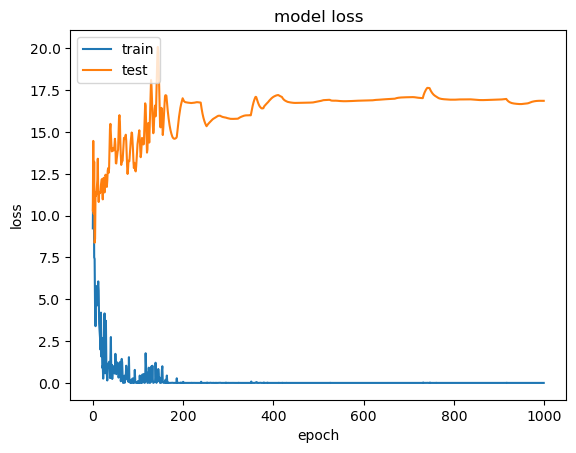

In [35]:
# Loss 
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

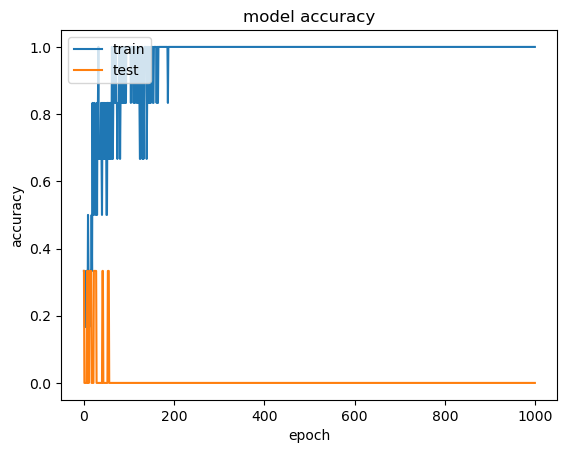

In [36]:
## This is for Accuracy
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
predictions = model.predict_classes(x_testcnn)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [38]:
predictions = (model.predict(x_testcnn) > 0.5).astype("int32")

1/1 [==============================] - 0s 83ms/step


In [39]:
predictions

array([[0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int32)

In [40]:
y_test

array([1, 5, 7])

In [41]:
new_Ytest = y_test.astype(int)

In [42]:
new_Ytest

array([1, 5, 7])

In [43]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [44]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [45]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/Users/arushtripathi/Downloads/sentiment-predictor-for-stress-detection-main/Saved_Models/'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/arushtripathi/Downloads/sentiment-predictor-for-stress-detection-main/Saved_Models/Emotion_Voice_Detection_Model.h5 


/Users/arushtripathi/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
from tensorflow import keras

from tensorflow.keras.models import load_model

from tensorflow.keras.utils import CustomObjectScope

from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):

    loaded_model = load_model('/Users/Snigdha1/Downloads/sentiment-predictor-for-stress-detection-main/Saved_Models/Emotion_Voice_Detection_Model.h5')
    loaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 40, 128)           768       
                                                                 
 activation_18 (Activation)  (None, 40, 128)           0         
                                                                 
 dropout_12 (Dropout)        (None, 40, 128)           0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 5, 128)            82048     
                                                                 
 activation_19 (Activation)  (None, 5, 128)            0         
                                                      

In [48]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1/1 [==============================] - 0s 66ms/step - loss: 16.8620 - accuracy: 0.0000e+00
Restored model, accuracy:  0.00%
